In [ ]:
%load_ext autoreload
%autoreload 2
import sys
import pandas as pd
import os
import matplotlib.pyplot as plt
import cortex
import seaborn as sns
from os.path import join
from collections import defaultdict
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib
import dvu
from copy import deepcopy
import sys
from numpy import ceil
sys.path.append('../notebooks')
from tqdm import tqdm
from neuro import config
from neuro.features.qa_questions import get_questions, get_merged_questions_v3_boostexamples
import neuro.sasc.viz
from PIL import Image
# from flatmaps_helper import VOX_COUNTS, load_custom_rois, load_known_rois, ROI_EXPLANATIONS_S03, FED_DRIVING_EXPLANATIONS_S03, FED_DRIVING_EXPLANATIONS_S02
from neuro.flatmaps_helper import load_flatmaps, load_custom_rois
import sys
from neuro import analyze_helper
neurosynth_compare = __import__('04_neurosynth_compare')
import neurosynth
from neuro.features.questions.gpt4 import QS_35_STABLE
import viz


subject = 'S02'
# subjects = [f'S0{i}' for i in range(1, 9) if not i == 6] # there's some problem with S06 surf2surf
subjects = ['S01', 'S02', 'S03', 'S08']

# load flatmaps
d = defaultdict(list)
for subject in subjects:
    # if subject in ['S01', 'S02', 'S03']:
    # settings = ['individual_gpt4',
    # 'individual_gpt4_wordrate', 'shapley_35']
    # else:
    settings = ['individual_gpt4_pc_new']
    flatmaps_qa_list = defaultdict(list)
    for setting in settings:
        flatmaps_qa_dict = joblib.load(
            join(config.PROCESSED_DIR, subject.replace('UT', ''), setting + '.pkl'))
        for q in flatmaps_qa_dict.keys():
            flatmaps_qa_list[q].append(flatmaps_qa_dict[q])
    flatmaps_qa_dict = {
        q: np.mean(flatmaps_qa_list[q], axis=0)
        for q in flatmaps_qa_list.keys()
    }
    # for k in sorted(flatmaps_qa_dict.keys()):
    for k in QS_35_STABLE:
        # print(k, flatmaps_qa_dict[k])
        # d[f'q_{subject}'].append(k)
        d[subject].append(flatmaps_qa_dict[k])

    # print(subject, len(flatmaps_qa_dict))
df = pd.DataFrame(d)
# df.set_index('q_S01', inplace=True)
df.index = QS_35_STABLE
df.index.name = 'question'
df = df[df.index.isin(QS_35_STABLE)]
assert df.shape[0] == 35

/home/chansingh/.env/lib/python3.11/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/chansingh/.env/lib/python3.11/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [5]:
data = joblib.load('../2_prediction/results_best_ensemble.pkl')
rr, cols_varied, mets = data['r'], data['cols_varied'], data['mets']
metric_sort = 'corrs_tune_pc_weighted_mean'
rr_best = rr[(rr.pc_components == 100) *
             (rr.ndelays == 8) *
             (rr.feature_space.str.contains('qa_emb')) *
             (rr.feature_selection_alpha < 0) *
             (rr.num_stories == -1) *
             (rr.qa_embedding_model == 'ensemble2')
             ]  # .sort_values(by='corrs_test_mean').iloc[-1]

### Select avg-response flatmaps

In [6]:
# select
avg_defaultdict = defaultdict(list)

for subject in ['S03', 'S08']:  # , 'S02']:
    gemv_flatmaps_dict = df[subject].to_dict()

    if subject == 'S02':
        rois_dict_fedorenko_S02 = load_custom_rois(
            subject='S02', suffix_setting='_fedorenko')
        sig = np.vstack(
            list(rois_dict_fedorenko_S02.values())).sum(axis=0).astype(bool)
    else:
        sig = rois_dict_fedorenko_sig['UT' + subject]
    rois_dict = {
        subject + ' lang': sig,
        subject + ' non-lang': ~sig,
    }

    corrs_35 = rr_best[rr_best.subject == subject]['corrs_test'].iloc[0]
    sig_well_predicted = corrs_35 > 0.1
    rois_dict[subject + ' lang\n(ρ>0.1)'] = sig_well_predicted & sig
    rois_dict[subject + ' non-lang\n(ρ>0.1)'] = sig_well_predicted & ~sig

    ##################################################
    # compute means
    # avg_defaultdict = defaultdict(list)
    for roi_idx, roi in rois_dict.items():
        for explanation in gemv_flatmaps_dict.keys():
            avg_defaultdict[roi_idx].append(
                np.mean(gemv_flatmaps_dict[explanation][roi > 0]))
            # corrs_defaultdict[roi_idx].append(
            # np.corrcoef(roi, gemv_flatmaps_dict[explanation])[0, 1])

In [7]:
d = pd.DataFrame(avg_defaultdict, index=gemv_flatmaps_dict.keys())
d['AVG'] = d.mean(axis=1)

# remove 2nd val of index
d.index = [analyze_helper.abbrev_question(q) for q in d.index]

d = d.round(3).sort_values('AVG', ascending=False)
# display pandas formatting with redblue colormap centered at 0 rounded to 3 decimal places
vabs = max(abs(d.values.min()), abs(d.values.max()))
d.style.background_gradient(cmap='coolwarm', axis=None, vmax=vabs, vmin=-vabs).format("{:.3f}").set_caption(
    'Average QA coefficients for different voxel subsets'
)

,S03 lang,S03 non-lang,S03 lang (ρ>0.1),S03 non-lang (ρ>0.1),S08 lang,S08 non-lang,S08 lang (ρ>0.1),S08 non-lang (ρ>0.1),AVG
...describe a personal or social interaction?,0.002,-0.000,0.003,0.000,0.006,-0.000,0.009,0.003,0.003
...describe a relationship between people?,0.005,0.000,0.007,0.000,0.005,-0.000,0.008,0.002,0.003
...describe a mode of communication?,0.002,0.000,0.003,0.001,0.004,-0.000,0.007,0.002,0.002
...discuss personal or social values?,0.002,-0.000,0.002,-0.001,0.001,0.001,0.001,0.001,0.001
...contain a proper noun?,0.002,0.001,0.003,0.000,-0.000,0.000,-0.000,-0.000,0.001
...describe a personal reflection or thought?,0.004,-0.000,0.005,-0.000,0.000,-0.000,0.000,0.000,0.001
...abstract rather than concrete?,0.005,-0.000,0.006,0.000,0.000,-0.000,0.001,-0.000,0.001
...express personal values or beliefs?,0.002,-0.000,0.002,-0.000,0.001,0.001,0.002,0.001,0.001
...include dialogue?,-0.000,-0.000,0.000,0.001,0.001,0.000,0.002,0.001,0.001
...contain a cultural reference?,0.003,-0.000,0.004,-0.000,0.000,0.000,-0.000,-0.000,0.001


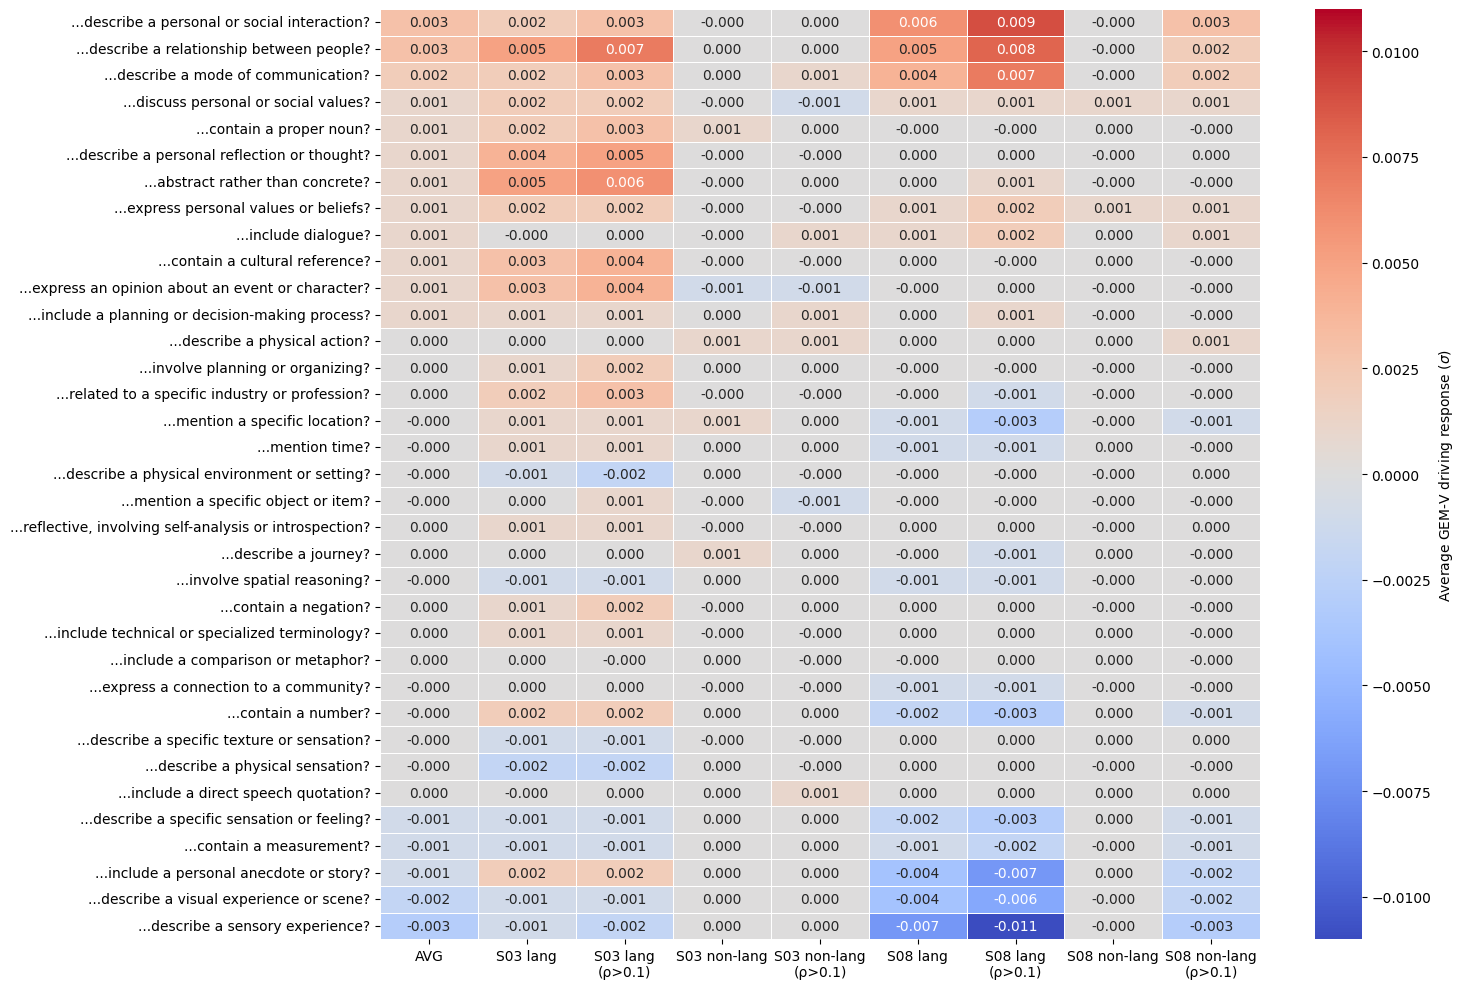

In [9]:
plt.figure(figsize=(15, 10))
# sort columns
d = d.reindex(sorted(d.columns), axis=1)

sns.heatmap(d, annot=True, fmt='.3f', cmap='coolwarm', center=0, vmin=-vabs, vmax=vabs,
            annot_kws={"size": 10}, cbar_kws={"label": "Average GEM-V driving response ($\\sigma$)"}, linewidths=.5)
plt.tight_layout()
plt.savefig('fed_drive_full.pdf')

In [ ]:
for subject in ['S03', 'S02']:
    if subject == 'S03':
        FED_DRIVING_EXPLANATIONS = FED_DRIVING_EXPLANATIONS_S03
    elif subject == 'S02':
        FED_DRIVING_EXPLANATIONS = FED_DRIVING_EXPLANATIONS_S02
    cols = [f'Lang-{i} {subject}' for i in range(4)]
    df_3 = df.loc[FED_DRIVING_EXPLANATIONS.values()][cols].rename(columns={
        k: k.replace(f' {subject}', '') for k in cols
    })
    plt.figure(figsize=(10, 6))
    # make fontsizes small
    sns.heatmap(df_3, annot=True, fmt='.3f', cmap='coolwarm', center=0, vmin=-vabs, vmax=vabs,
                cbar_kws={"label": "Average GEM-V driving response"}, linewidths=.5)
    dvu.outline_diagonal(df_3.values.shape, roffset=0.5,
                         coffset=0.5, color='black', lw=2)
    plt.tight_layout()
    plt.savefig(f'fed_drive_{subject}.pdf', bbox_inches='tight')

In [ ]:
# neuro.sasc.viz._save_flatmap(
#     gemv_flatmaps_dict[('relationships between people', 'qa')], subject, fname_save=f'gemv_flatmaps/relationships_{subject}.png')

# Show flatmaps across subjects

In [ ]:
S02_flatmaps_dir = join(RESULTS_DIR, 'processed',
                        'flatmaps_all', 'UTS02', 'roi')
S03_flatmaps_dir = join(RESULTS_DIR, 'processed',
                        'flatmaps_all', 'UTS03', 'roi')

In [ ]:
# read a list of pngs and save them as a grid
for COMPARISONS in [
    ['Years', 'Time', 'Numbers', 'Measurements'],
    ['Relationships', 'Dialogue', 'Introspection'],
    ['Gruesome', 'Fear', 'Positive Emotional', 'Negative Emotional'],
    ['Clothing', 'Color'],
    ['Sexual', 'Secretive', 'Recognition', 'Professions']
]:

    pngs = defaultdict(list)
    for s in COMPARISONS:
        pngs['S02'] += [join(S02_flatmaps_dir, f)
                        for f in os.listdir(S02_flatmaps_dir) if f.endswith('.png') and s in f]
        pngs['S03'] += [join(S03_flatmaps_dir, f)
                        for f in os.listdir(S03_flatmaps_dir) if f.endswith('.png') and s in f]

    # plot as grid
    fig, axes = plt.subplots(
        2, len(COMPARISONS), figsize=(len(COMPARISONS) * 5, 6))
    for i, ax in enumerate(axes.flatten()):
        # ax.axis('off')
        # Remove all x-axis ticks and labels
        ax.xaxis.set_ticks([])
        ax.xaxis.set_ticklabels([])
        ax.xaxis.label.set_visible(False)

        # Remove all y-axis ticks and labels (but keep the y-axis label)
        ax.yaxis.set_ticks([])
        ax.yaxis.set_ticklabels([])

        for spine in ax.spines.values():
            spine.set_visible(False)

    for i in range(len(COMPARISONS)):
        axes[0, i].imshow(plt.imread(pngs['S02'][i]))
        axes[0, i].set_title(COMPARISONS[i])
        axes[1, i].imshow(plt.imread(pngs['S03'][i]))
        axes[0, 0].set_ylabel('S02')
        axes[1, 0].set_ylabel('S03')

    # add
    plt.savefig('__'.join(COMPARISONS) + '.png', bbox_inches='tight', dpi=300)
    plt.show()